In [15]:
import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import timedelta
from datetime import datetime
from sklearn.utils.extmath import safe_sparse_dot

In [16]:
pandas_df = pd.read_csv('soh_daily.csv', index_col=None)
pandas_df.reset_index(drop=True, inplace=True)
pandas_df = pandas_df[['soh','event_time','uid','manufacturer','capacity_ah']].copy()
pandas_df

,soh,event_time,uid,manufacturer,capacity_ah
0,100,2022-09-13 12:49:32,PZ4eI6JvRR2upzA_1,Vision,100
1,100,2022-09-13 12:49:32,PZ4eI6JvRR2upzA_2,Vision,100
2,100,2022-09-14 00:00:05,PZ4eI6JvRR2upzA_1,Vision,100
3,100,2022-09-14 00:00:05,PZ4eI6JvRR2upzA_2,Vision,100
4,100,2022-09-15 00:01:27,PZ4eI6JvRR2upzA_2,Vision,100
...,...,...,...,...,...
8611,100,2023-10-15 00:01:00,PL2GJFloWT7Gsnw_4,Vision,100
8612,100,2023-10-15 00:01:00,PL2GJFloWT7Gsnw_2,Vision,100
8613,99,2023-10-15 00:03:00,PL2GJFloWT7Gsnw_3,Vision,100
8614,92,2023-10-15 00:03:00,PAKDwUxCcrkFUu5Y_1,Vision,100


In [17]:
result = pandas_df.groupby('uid')['event_time'].agg(['min', 'max']).reset_index()
result

,uid,min,max
0,PAJRdGT0GMkZNj1U_1,2023-04-06 16:24:00,2023-10-06 00:01:00
1,PAJRdGT0GMkZNj1U_2,2023-04-15 15:45:00,2023-10-06 00:01:00
2,PAJRdGT0GMkZNj1U_3,2023-04-15 15:48:00,2023-10-06 00:02:00
3,PAJgI2wNpnEaIpRw_1,2022-09-26 11:58:22,2023-10-15 00:00:00
4,PAJgI2wNpnEaIpRw_2,2022-09-26 19:59:32,2023-10-15 00:00:00
5,PAJgI2wNpnEaIpRw_3,2022-09-26 20:00:14,2023-10-15 00:01:00
6,PAJgI2wNpnEaIpRw_4,2022-09-26 20:05:03,2023-10-15 00:00:00
7,PAKDwUxCcrkFUu5Y_1,2022-09-21 12:45:25,2023-10-15 00:03:00
8,PAKDwUxCcrkFUu5Y_2,2022-10-03 16:42:32,2023-10-15 00:00:00
9,PAKDwUxCcrkFUu5Y_3,2022-10-03 16:42:33,2023-10-15 00:00:00


In [18]:
# Function to create time series dataset
def create_dataset(X, y, time_steps, initial_date):
    Xs, ys, dates = [], [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
        dates.append(initial_date)
        initial_date = initial_date + timedelta(days=1)
    return np.array(Xs), np.array(ys), np.array(dates)

Root Mean Squared Error during Training: 0.0903140548589231


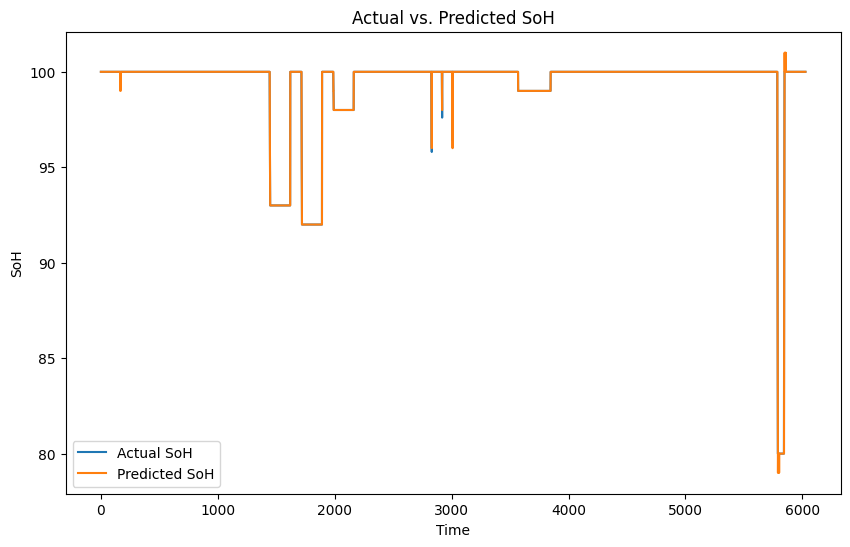

In [19]:
split_index = int(len(pandas_df) * 0.75) # Splitting 3/4th for training and 1/4th for testing
train_df = pandas_df[:split_index]
test_df = pandas_df[split_index:]

# Grouping the DataFrame by battery_name
groups_train = train_df.groupby('uid')
groups_test = test_df.groupby('uid')

# Iterate over each group and train a linear regression model
models = {}
lr_model = LinearRegression()
TIME_STEPS = 15  # Choose the number of past time steps to consider (Also the number of features to give to model)
# Training model on all the data
initial_training_X = np.empty((0,TIME_STEPS))
initial_training_y = np.empty(0)
initial_training_dates = np.empty(0)
for name, group in groups_train:
    group['rolling_soh'] = group['soh'].rolling(5).mean()
    group['rolling_soh'] = group['rolling_soh'].fillna(method='bfill')
    
    initial_date = group['event_time'].iloc[TIME_STEPS]
    initial_date = datetime.strptime(initial_date, '%Y-%m-%d %H:%M:%S')
    X, y, dates = create_dataset(group['rolling_soh'], group['rolling_soh'], TIME_STEPS, initial_date)
    
    initial_training_X = np.concatenate((initial_training_X, X))
    initial_training_y = np.concatenate((initial_training_y, y))
    initial_training_dates = np.concatenate((initial_training_dates, dates))



lr_model.fit(initial_training_X, initial_training_y)
y_pred = lr_model.predict(initial_training_X)

y_pred = np.round(y_pred, decimals=0)
rmse_training = np.sqrt(mean_squared_error(initial_training_y, y_pred))
print("Root Mean Squared Error during Training:", rmse_training)

# plotting matplotlib
plt.figure(figsize=(10, 6))
plt.plot(initial_training_y, label='Actual SoH')
plt.plot(y_pred, label='Predicted SoH')
plt.xlabel('Time')
plt.ylabel('SoH')
plt.title('Actual vs. Predicted SoH')
plt.legend()
plt.show()

# plotting plotly
plotting_df = pd.DataFrame({
    'Date': initial_training_dates,
    'Actual Rolling SoH': initial_training_y,
    'Predicted SoH': y_pred
})
df_melted = plotting_df.reset_index().melt(id_vars='index', value_vars=['Actual Rolling SoH', 'Predicted SoH'], var_name='Variable', value_name='SoH')
fig = px.line(df_melted, x='index', y='SoH',  color='Variable', title='Actual v Predicted SoH Rolling SoH Model')
fig.show()


    

In [20]:
# Using model to predict soh on test data
def predict_test_data(model, groups_test):
    for name, group in groups_test:
        print("For battery ", name)
        battery_df = group
        battery_df['rolling_soh'] = battery_df['soh'].rolling(5).mean()
        battery_df['rolling_soh'] = battery_df['rolling_soh'].fillna(method='bfill')
        initial_date = group['event_time'].iloc[TIME_STEPS]
        initial_date = datetime.strptime(initial_date, '%Y-%m-%d %H:%M:%S')
        X, y, dates = create_dataset(battery_df['rolling_soh'], battery_df['rolling_soh'], TIME_STEPS, initial_date)
        y_pred = model.predict(X)
        y_pred = np.round(y_pred, decimals=0)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        print("Root Mean Squared Error on testing dataset:", rmse)
        print(y)
        print(y_pred)

        bms_soh = battery_df['soh'].iloc[TIME_STEPS:]

        # Plotting plotly
        plotting_df = pd.DataFrame({
            'Date': dates,
            'Actual Rolling SoH': y,
            'BMS SoH': bms_soh,
            'Predicted SoH': y_pred
        })
        plotting_df = plotting_df.melt(id_vars='Date', value_vars=['BMS SoH', 'Predicted SoH'], var_name='Type', value_name='SoH')
        fig = px.line(plotting_df, x='Date', y='SoH',  color='Type', title='Actual v Predicted SoH Rolling SoH Model')
        fig.show()


predict_test_data(lr_model, groups_test)
        

For battery  PAJRdGT0GMkZNj1U_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJRdGT0GMkZNj1U_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJRdGT0GMkZNj1U_3
Root Mean Squared Error on testing dataset: 0.6761234037828132
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100.  96.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJgI2wNpnEaIpRw_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJgI2wNpnEaIpRw_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJgI2wNpnEaIpRw_3
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJgI2wNpnEaIpRw_4
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAKDwUxCcrkFUu5Y_1
Root Mean Squared Error on testing dataset: 0.07968190728896071
[93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.
 93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  92.8
 92.6 92.4 92.2 92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.
 92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.
 92.  92.  92.  92.  92.  92.  92. ]
[93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 92. 92. 92. 92. 92. 92. 92.
 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92.
 92. 92. 92. 92. 92. 92. 92. 92. 92.]


For battery  PAKDwUxCcrkFUu5Y_2
Root Mean Squared Error on testing dataset: 0.09759000729485331
[92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.
 92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  91.4
 90.8 90.2 89.6 89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
 89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
 89.  89.  89.  89.  89.  89.  89. ]
[92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92.
 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 91. 90. 90. 89. 89. 89. 89. 89.
 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89.
 89. 89. 89. 89. 89. 89. 89. 89. 89.]


For battery  PAKDwUxCcrkFUu5Y_3
Root Mean Squared Error on testing dataset: 0.0
[98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.]
[98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.]


For battery  PAKDwUxCcrkFUu5Y_4
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAKDwUxCcrkFUu5Y_5
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PANzW2MEeq0RCuC4_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PANzW2MEeq0RCuC4_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PANzW2MEeq0RCuC4_3
Root Mean Squared Error on testing dataset: 0.0
[93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.]
[93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.]


For battery  PANzW2MEeq0RCuC4_4
Root Mean Squared Error on testing dataset: 0.0
[96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.]
[96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.]


For battery  PANzW2MEeq0RCuC4_5
Root Mean Squared Error on testing dataset: 0.0
[94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.]
[94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.]


For battery  PL2GJFloWT7Gsnw_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PL2GJFloWT7Gsnw_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PL2GJFloWT7Gsnw_3
Root Mean Squared Error on testing dataset: 0.0
[99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.]
[99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.]


For battery  PL2GJFloWT7Gsnw_4
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PNYtiho1XRna3gw_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PNYtiho1XRna3gw_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PNYtiho1XRna3gw_3
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PNYtiho1XRna3gw_4
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PNYtiho1XRna3gw_5
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PZ4eI6JvRR2upzA_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PZ4eI6JvRR2upzA_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PZ4eI6JvRR2upzA_3
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


In [21]:
lr_model.coef_, lr_model.intercept_

(array([ 0.052088  , -0.05068937, -0.00479744, -0.30822225,  0.64411152,
        -0.29858863, -0.03178107, -0.00892489, -0.61643804,  1.28822311,
        -0.64926527, -0.01287277, -0.01305234, -0.92465385,  1.93233413]),
 0.2498426877351818)

In [22]:
# Function to use coefficients and intercept of Linear Regressor to predict on X
def predict_soh(X, coef, intercept):
    return safe_sparse_dot(X, coef.T,
                       dense_output=True) + intercept

def predict_test_data_offline(groups_test, coef, intercept):
    rmses = []
    for name, group in groups_test:
        print("For battery ", name)
        battery_df = group
        battery_df['rolling_soh'] = battery_df['soh'].rolling(5).mean()
        battery_df['rolling_soh'] = battery_df['rolling_soh'].fillna(method='bfill')
        initial_date = group['event_time'].iloc[TIME_STEPS]
        initial_date = datetime.strptime(initial_date, '%Y-%m-%d %H:%M:%S')
        X, y, dates = create_dataset(battery_df['rolling_soh'], battery_df['rolling_soh'], TIME_STEPS, initial_date)
        y_pred = predict_soh(X, coef, intercept)
        y_pred = np.round(y_pred, decimals=0)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        rmses.append(rmse)
        print("Root Mean Squared Error on testing dataset:", rmse)

        bms_soh = battery_df['soh'].iloc[TIME_STEPS:]

        # Plotting plotly
        plotting_df = pd.DataFrame({
            'Date': dates,
            'Actual Rolling SoH': y,
            'BMS SoH': bms_soh,
            'Predicted SoH': y_pred
        })
        plotting_df = plotting_df.melt(id_vars='Date', value_vars=['BMS SoH', 'Predicted SoH'], var_name='Type', value_name='SoH')
        fig = px.line(plotting_df, x='Date', y='SoH',  color='Type', title='Actual v Predicted SoH Rolling SoH Model')
        fig.show()

    avg_rmse = sum(rmses) / len(rmses)
    return avg_rmse

# Predicting using predict_soh
avg_rmse = predict_test_data_offline(groups_test,lr_model.coef_, lr_model.intercept_)
print("Average Root Mean Square Error on all 29 stationary batteries test data: ", avg_rmse)

For battery  PAJRdGT0GMkZNj1U_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PAJRdGT0GMkZNj1U_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PAJRdGT0GMkZNj1U_3
Root Mean Squared Error on testing dataset: 0.6761234037828132


For battery  PAJgI2wNpnEaIpRw_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PAJgI2wNpnEaIpRw_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PAJgI2wNpnEaIpRw_3
Root Mean Squared Error on testing dataset: 0.0


For battery  PAJgI2wNpnEaIpRw_4
Root Mean Squared Error on testing dataset: 0.0


For battery  PAKDwUxCcrkFUu5Y_1
Root Mean Squared Error on testing dataset: 0.07968190728896071


For battery  PAKDwUxCcrkFUu5Y_2
Root Mean Squared Error on testing dataset: 0.09759000729485331


For battery  PAKDwUxCcrkFUu5Y_3
Root Mean Squared Error on testing dataset: 0.0


For battery  PAKDwUxCcrkFUu5Y_4
Root Mean Squared Error on testing dataset: 0.0


For battery  PAKDwUxCcrkFUu5Y_5
Root Mean Squared Error on testing dataset: 0.0


For battery  PANzW2MEeq0RCuC4_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PANzW2MEeq0RCuC4_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PANzW2MEeq0RCuC4_3
Root Mean Squared Error on testing dataset: 0.0


For battery  PANzW2MEeq0RCuC4_4
Root Mean Squared Error on testing dataset: 0.0


For battery  PANzW2MEeq0RCuC4_5
Root Mean Squared Error on testing dataset: 0.0


For battery  PL2GJFloWT7Gsnw_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PL2GJFloWT7Gsnw_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PL2GJFloWT7Gsnw_3
Root Mean Squared Error on testing dataset: 0.0


For battery  PL2GJFloWT7Gsnw_4
Root Mean Squared Error on testing dataset: 0.0


For battery  PNYtiho1XRna3gw_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PNYtiho1XRna3gw_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PNYtiho1XRna3gw_3
Root Mean Squared Error on testing dataset: 0.0


For battery  PNYtiho1XRna3gw_4
Root Mean Squared Error on testing dataset: 0.0


For battery  PNYtiho1XRna3gw_5
Root Mean Squared Error on testing dataset: 0.0


For battery  PZ4eI6JvRR2upzA_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PZ4eI6JvRR2upzA_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PZ4eI6JvRR2upzA_3
Root Mean Squared Error on testing dataset: 0.0


Average Root Mean Square Error on all 29 stationary batteries test data:  0.02942742477126301


In [23]:
# Exporting LR Model
import pickle
with open('soh_rolling_avg_v1.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

In [24]:
# Exporting Coefficients and Intercept
with open('soh_rolling_avg_v1_coef.pkl', 'wb') as file:
    pickle.dump(lr_model.coef_, file)
with open('soh_rolling_avg_v1_intercept.pkl', 'wb') as file:
    pickle.dump(lr_model.intercept_, file)

In [25]:
# Import LR Model
with open('soh_rolling_avg_v1.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

predict_test_data(loaded_model, groups_test)

For battery  PAJRdGT0GMkZNj1U_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJRdGT0GMkZNj1U_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJRdGT0GMkZNj1U_3
Root Mean Squared Error on testing dataset: 0.6761234037828132
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100.  96.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJgI2wNpnEaIpRw_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJgI2wNpnEaIpRw_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJgI2wNpnEaIpRw_3
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAJgI2wNpnEaIpRw_4
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAKDwUxCcrkFUu5Y_1
Root Mean Squared Error on testing dataset: 0.07968190728896071
[93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.
 93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  93.  92.8
 92.6 92.4 92.2 92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.
 92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.
 92.  92.  92.  92.  92.  92.  92. ]
[93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 92. 92. 92. 92. 92. 92. 92.
 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92.
 92. 92. 92. 92. 92. 92. 92. 92. 92.]


For battery  PAKDwUxCcrkFUu5Y_2
Root Mean Squared Error on testing dataset: 0.09759000729485331
[92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.
 92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  92.  91.4
 90.8 90.2 89.6 89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
 89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
 89.  89.  89.  89.  89.  89.  89. ]
[92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 92.
 92. 92. 92. 92. 92. 92. 92. 92. 92. 92. 91. 90. 90. 89. 89. 89. 89. 89.
 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89. 89.
 89. 89. 89. 89. 89. 89. 89. 89. 89.]


For battery  PAKDwUxCcrkFUu5Y_3
Root Mean Squared Error on testing dataset: 0.0
[98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.]
[98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.
 98. 98. 98. 98. 98. 98. 98. 98. 98. 98.]


For battery  PAKDwUxCcrkFUu5Y_4
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PAKDwUxCcrkFUu5Y_5
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PANzW2MEeq0RCuC4_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PANzW2MEeq0RCuC4_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PANzW2MEeq0RCuC4_3
Root Mean Squared Error on testing dataset: 0.0
[93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.]
[93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.
 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93. 93.]


For battery  PANzW2MEeq0RCuC4_4
Root Mean Squared Error on testing dataset: 0.0
[96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.]
[96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.
 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96. 96.]


For battery  PANzW2MEeq0RCuC4_5
Root Mean Squared Error on testing dataset: 0.0
[94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.]
[94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.
 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94. 94.]


For battery  PL2GJFloWT7Gsnw_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PL2GJFloWT7Gsnw_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PL2GJFloWT7Gsnw_3
Root Mean Squared Error on testing dataset: 0.0
[99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.]
[99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.]


For battery  PL2GJFloWT7Gsnw_4
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PNYtiho1XRna3gw_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PNYtiho1XRna3gw_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PNYtiho1XRna3gw_3
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PNYtiho1XRna3gw_4
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PNYtiho1XRna3gw_5
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PZ4eI6JvRR2upzA_1
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PZ4eI6JvRR2upzA_2
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


For battery  PZ4eI6JvRR2upzA_3
Root Mean Squared Error on testing dataset: 0.0
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


In [26]:
# Importing Coefficients and Intercept
with open('soh_rolling_avg_v1_coef.pkl', 'rb') as file:
    loaded_coef = pickle.load(file)
with open('soh_rolling_avg_v1_intercept.pkl', 'rb') as file:
    loaded_intercept = pickle.load(file)

predict_test_data_offline(groups_test, loaded_coef, loaded_intercept)

For battery  PAJRdGT0GMkZNj1U_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PAJRdGT0GMkZNj1U_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PAJRdGT0GMkZNj1U_3
Root Mean Squared Error on testing dataset: 0.6761234037828132


For battery  PAJgI2wNpnEaIpRw_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PAJgI2wNpnEaIpRw_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PAJgI2wNpnEaIpRw_3
Root Mean Squared Error on testing dataset: 0.0


For battery  PAJgI2wNpnEaIpRw_4
Root Mean Squared Error on testing dataset: 0.0


For battery  PAKDwUxCcrkFUu5Y_1
Root Mean Squared Error on testing dataset: 0.07968190728896071


For battery  PAKDwUxCcrkFUu5Y_2
Root Mean Squared Error on testing dataset: 0.09759000729485331


For battery  PAKDwUxCcrkFUu5Y_3
Root Mean Squared Error on testing dataset: 0.0


For battery  PAKDwUxCcrkFUu5Y_4
Root Mean Squared Error on testing dataset: 0.0


For battery  PAKDwUxCcrkFUu5Y_5
Root Mean Squared Error on testing dataset: 0.0


For battery  PANzW2MEeq0RCuC4_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PANzW2MEeq0RCuC4_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PANzW2MEeq0RCuC4_3
Root Mean Squared Error on testing dataset: 0.0


For battery  PANzW2MEeq0RCuC4_4
Root Mean Squared Error on testing dataset: 0.0


For battery  PANzW2MEeq0RCuC4_5
Root Mean Squared Error on testing dataset: 0.0


For battery  PL2GJFloWT7Gsnw_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PL2GJFloWT7Gsnw_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PL2GJFloWT7Gsnw_3
Root Mean Squared Error on testing dataset: 0.0


For battery  PL2GJFloWT7Gsnw_4
Root Mean Squared Error on testing dataset: 0.0


For battery  PNYtiho1XRna3gw_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PNYtiho1XRna3gw_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PNYtiho1XRna3gw_3
Root Mean Squared Error on testing dataset: 0.0


For battery  PNYtiho1XRna3gw_4
Root Mean Squared Error on testing dataset: 0.0


For battery  PNYtiho1XRna3gw_5
Root Mean Squared Error on testing dataset: 0.0


For battery  PZ4eI6JvRR2upzA_1
Root Mean Squared Error on testing dataset: 0.0


For battery  PZ4eI6JvRR2upzA_2
Root Mean Squared Error on testing dataset: 0.0


For battery  PZ4eI6JvRR2upzA_3
Root Mean Squared Error on testing dataset: 0.0


0.02942742477126301